# Case study with a single family

Tom Ellis, May 2017

In [3]:
import numpy as np
from faps import *
#import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data inspection

Import genotype data for the reproductive adults, and the offspring of mother M0009. The latter includes information on the ID of the maternal mother.

In [4]:
m9 = read_genotypes('./data_files/M0009_offspring.csv', mothers_col=1, genotype_col=2)
adults = read_genotypes('./data_files/parents_SNPs_2012.csv')

As a sanity check, confirm that the marker names really do match.

In [3]:
all([m9.markers[i] == adults.markers[i] for i in range(69)])

True

Tissue from the adults and progeny was dried in different ways. For the progeny, I didnt use enough silica gel to dry the tissue rapidly, and the DNA became degraded. Reflecting this, although genotype dropouts (the rate at which genotype information at a single locus fails to amplify) is respectable for the adults, but dire for the offspring.

In [4]:
print adults.missing_data().max()
print m9.missing_data().max()


0.027972027972
0.560975609756


Luckily a lot of this is driven by a small number of loci/individuals with very high dropout rates, although there are still an alaraming proportion of loci with 5-10% dropouts.

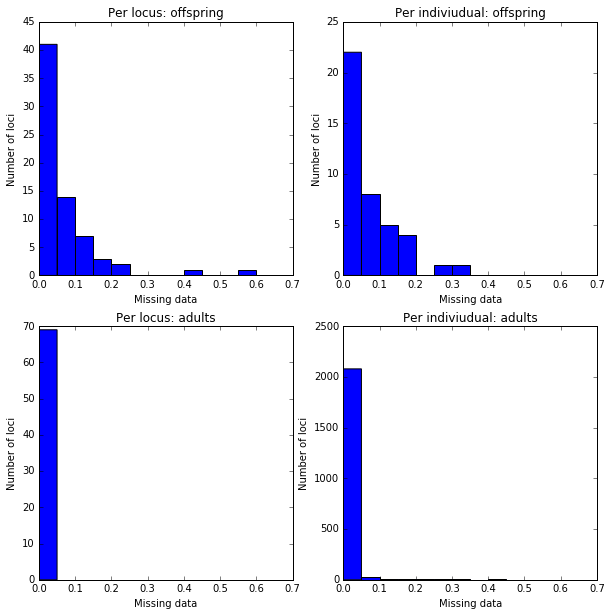

In [5]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

mdo = fig.add_subplot(2,2,1)
mdo.hist(m9.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mdo.set_xlabel("Missing data")
mdo.set_ylabel("Number of loci")
mdo.set_title('Per locus: offspring')

indo = fig.add_subplot(2,2,2)
indo.hist(m9.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
indo.set_xlabel("Missing data")
indo.set_ylabel("Number of loci")
indo.set_title('Per indiviudual: offspring')

mda = fig.add_subplot(2,2,3)
mda.hist(adults.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mda.set_xlabel("Missing data")
mda.set_ylabel("Number of loci")
mda.set_title('Per locus: adults')

inda = fig.add_subplot(2,2,4)
inda.hist(adults.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
inda.set_xlabel("Missing data")
inda.set_ylabel("Number of loci")
inda.set_title('Per indiviudual: adults')

Although overall per locus drop-out rates are low for the adults, there are some individuals with alarmingly high amounts of missing data. Candidates with very few loci typed can come out as being highly compatible with many offspring, just because there is insufficient information to exclude them.

In [6]:
print adults.missing_data(by='individual').max()
print m9.missing_data('individual').max()

0.898550724638
0.304347826087


We can remove 11 offspring and 32 adults individuals with 10% or more dropouts.

In [5]:
print np.array(m9.names)[m9.missing_data(1) > 0.1]
print np.array(adults.names)[adults.missing_data(1) > 0.1]

m9     = m9.subset(    individuals= m9.missing_data(1) < 0.1)
adults = adults.subset(individuals= adults.missing_data(1) < 0.1)

['M0009_1' 'M0009_2' 'M0009_3' 'M0009_5' 'M0009_6' 'M0009_7' 'M0009_9'
 'M0009_11' 'M0009_152' 'M0009_159' 'M0009_164']
['L1471' 'L1477' 'M0014' 'M0029' 'M0044' 'M0151' 'M0164' 'M0196' 'M0246'
 'M0302' 'M0457' 'M0500' 'M0530' 'M0546' 'M0568' 'M0612' 'M0660' 'M0847'
 'M0963' 'M1127' 'M1143' 'M1243' 'M1582' 'M1588' 'M1592' 'M1636' 'M1712'
 'M1720' 'M1747' 'M1752' 'M1755' 'M1822' 'M1907' 'M1960' 'M2014' 'M2042']


Histograms look much better. It would still worth removing some of the dubious loci with high drop-out rates though.

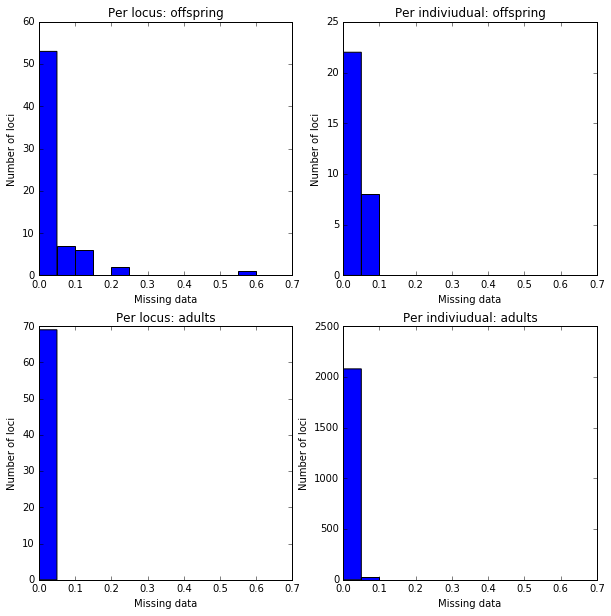

In [8]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

mdo = fig.add_subplot(2,2,1)
mdo.hist(m9.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mdo.set_xlabel("Missing data")
mdo.set_ylabel("Number of loci")
mdo.set_title('Per locus: offspring')

indo = fig.add_subplot(2,2,2)
indo.hist(m9.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
indo.set_xlabel("Missing data")
indo.set_ylabel("Number of loci")
indo.set_title('Per indiviudual: offspring')

mda = fig.add_subplot(2,2,3)
mda.hist(adults.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mda.set_xlabel("Missing data")
mda.set_ylabel("Number of loci")
mda.set_title('Per locus: adults')

inda = fig.add_subplot(2,2,4)
inda.hist(adults.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
inda.set_xlabel("Missing data")
inda.set_ylabel("Number of loci")
inda.set_title('Per indiviudual: adults')

Remove the 4 loci with dropouts >10% from both the offspring and adult datasets.

In [6]:
print np.array(m9.markers)[m9.missing_data(0) >= 0.1]

m9     = m9.subset(    loci= m9.missing_data(0) < 0.1)
adults = adults.subset(loci= m9.missing_data(0) < 0.1)

['s930_115738' 's1348_19294' 's549_1270640' 's1228_247128' 's338_787544'
 's720_870524' 's217_2722063' 's494_499812' 's117reverse_156993']


Allele frequency and heterozygosity show the convex pattern one would expect. There seem to be four loci with heterozygosity below 0.2 which I will also remove.

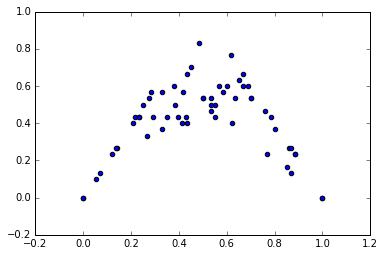

In [10]:
plt.scatter(m9.allele_freqs(), m9.heterozygosity(0))
plt.show()

Loci with low heterozygosity are not dangerous in themselves; they might contribute some information, albeit little. To be on the safe side, let's remove loci with less than 0.1 heterozygosity.

In [7]:
print m9.markers[adults.heterozygosity(0) < 0.25]
m9     = m9.subset(    loci= adults.heterozygosity(0) > 0.1)
adults = adults.subset(loci= adults.heterozygosity(0) > 0.1)

['s117reverse_8996' 's117reverse_186395' 's804_404293' 's88_362224']


This leaves us with a dataset of 55 loci for which allele frequency and heterozygosity are highest around 0.5, which is good. In particular, heterozygosity (and hence homozygosity) among the adults is humped around 0.5, which is a good sign that parents should be readily distinguishable. There is nevertheless substantial spread towards zero and one for the progeny data however, which is less than ideal.

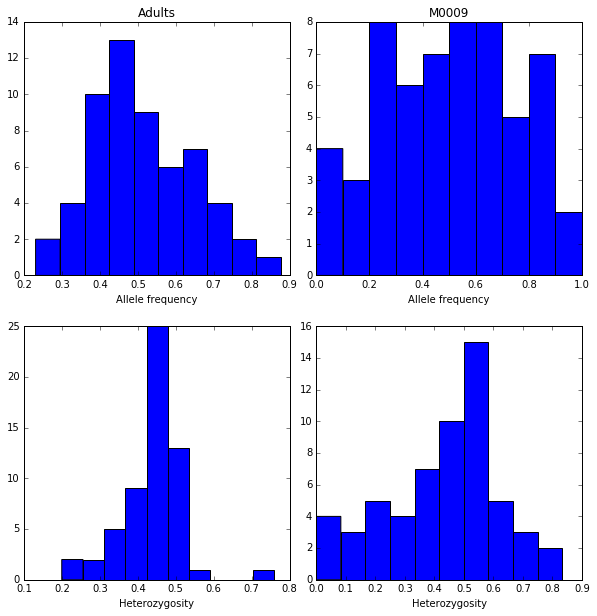

In [12]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.1, hspace=0.2)

afp = fig.add_subplot(2,2,1)
afp.hist(adults.allele_freqs())
afp.set_title('Adults')
afp.set_xlabel("Allele frequency")

afo = fig.add_subplot(2,2,2)
afo.hist(m9.allele_freqs())
afo.set_title('M0009')
afo.set_xlabel("Allele frequency")

hetp = fig.add_subplot(2,2,3)
hetp.hist(adults.heterozygosity(0))
hetp.set_xlabel("Heterozygosity")

heto = fig.add_subplot(2,2,4)
heto.hist(m9.heterozygosity(0))
heto.set_xlabel("Heterozygosity")

The effective number of loci can be seen as the number of loci at which one can make compare the offspring, maternal and candidate paternal genotype (i.e. those loci with no missing data). Given how high dropouts are in the offspring, it is worthwhile to check the effective number of loci for this dataset.

In fact, effective number of loci is good. The minimum number of valid loci to compare is 46, and in 99% of cases there are 50 or more loci.

Finally, print some summary statistics about the quality of the genotype information in the data set.

In [31]:
print m9.missing_data(0).mean()
print adults.missing_data(0).mean()
print adults.heterozygosity(0).min(), adults.heterozygosity(0).max()

0.017816091954
0.00884550612318
0.199620673305 0.759127548601


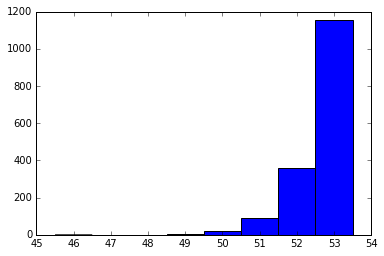

In [14]:
mothers = adults.subset(m9.parent_index('m', adults.names))


mat = (m9.geno[:,:,0] == -9)[np.newaxis] + (mothers.geno[:,:,0] == -9)[np.newaxis] + (adults.geno[:,:,0] == -9)[:, np.newaxis]
missing = m9.nloci - (mat > 0).sum(2)
plt.hist(missing.flatten(), bins=np.arange(45.5,54.5))
plt.show()

## Sibship inference

In [8]:
mothers = adults.subset(m9.parent_index('m', adults.names))
allele_freqs = adults.allele_freqs()
patlik = paternity_array(m9, mothers, adults, allele_freqs, 0.0013)
sc = sibship_clustering(patlik, 10000)

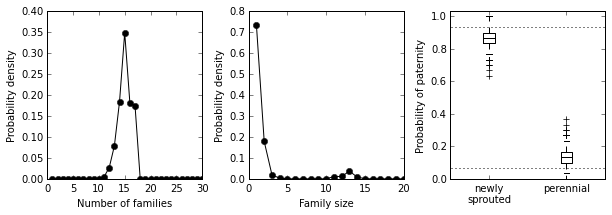

In [55]:
fig = plt.figure(figsize=(10, 3))
fig.subplots_adjust(wspace=0.3, hspace=0.1)

nf = fig.add_subplot(1,3,1)
nf.set_ylabel('Probability density')
nf.set_xlabel('Number of families')
nf.set_ylim(0,0.4)
nf.plot(range(1,31), sc.nfamilies(), '-ok')

fs = fig.add_subplot(1,3,2)
fs.set_xlabel('Family size')
fs.set_ylabel('Probability density')
fs.plot(range(1,21), sc.family_size()[:20], '-ok')

pr = fig.add_subplot(1,3,3)
bp = pr.boxplot(obs/30)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black')
plt.xticks([1,2], ['newly\nsprouted','perennial'])
plt.ylim([0, 1.03])
#plt.xlabel('Date recorded')
plt.ylabel('Probability of paternity')
#plt.grid(axis='y')
plt.plot([0,3], [labcounts[0], labcounts[0]], ':k')
plt.plot([0,3], [labcounts[1], labcounts[1]], ':k')

plt.savefig('./figures/M0009_mating.eps', bbox_inches='tight', pad_inches=0.1)

In [68]:
phenotypes = np.zeros(len(patlik.candidates))
phenotypes[maternal_index] = 1
pr = sc.prob_mating(phenotypes, ndraws=10000)
print pr

(['0.0', '1.0', 'absent'], array([ -3.63561231e-05,             -inf,  -1.02221661e+01]))


In [50]:
labcounts = np.unique([adults.names[i][0] for i in range(adults.size)], return_counts=True)[1]
labcounts = labcounts.astype('float') / labcounts.sum()
labcounts

array([ 0.0649597,  0.9350403])

In [93]:
np.percentile(obs[:,1]/30, 97.5)

0.26666666666666666

In [51]:
surv_prob = np.where(np.array(surv) == 'L', labcounts[0], labcounts[1])
surv_prob = surv_prob / surv_prob.sum()

In [52]:
surv = [adults.names[i][0] for i in range(adults.size)]
pr2  = sc.prob_mating(surv, surv_prob, ndraws=10000)

faps/draw_fathers.py:79: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  null_samples = null_samples[valid]


In [90]:
obs = np.random.multinomial(30, np.exp(pr2[1]), 1000).astype('float')[:,1:]
exp = labcounts[np.newaxis, [1,0]] * 30

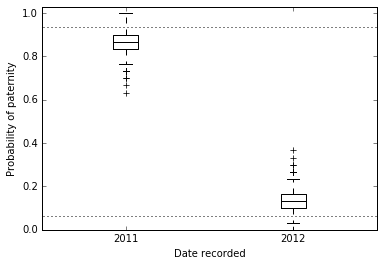

In [203]:
fig.set_size_inches(8/2.54, 8/2.54)
plt.savefig('figures/m9_perennial_mating.eps')